# PA005: High Value Customer Identification (Insiders)

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">0.0. Imports</p></div>

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import inflection
import sqlalchemy
import sqlite3
import pickle
import s3fs
import re
import os

import matplotlib.cm as cm
from matplotlib        import pyplot as plt
from plotly            import express as px

from sklearn           import cluster as c
from sklearn           import metrics as mt
from sklearn           import ensemble as en
from sklearn           import preprocessing as pp
from sklearn           import decomposition as dd
from sklearn           import mixture as mx
from sklearn.manifold  import TSNE
from sklearn.neighbors import NearestNeighbors

from decouple import config
from scipy.cluster     import hierarchy as hc
import umap.umap_ as umap
import warnings
warnings.filterwarnings( 'ignore' )

/home/luanmaieski/.pyenv/versions/3.11.4/envs/pa005clustering/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/luanmaieski/.pyenv/versions/3.11.4/envs/pa005clustering/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/luanmaiesk

In [2]:
plt.rcParams['figure.figsize'] = [15, 5]

In [2]:
AWS_ACCESS_KEY_ID = os.environ.get( 'AWS_ACCESS_KEY_ID' )
AWS_SECRET_ACCESS_KEY = os.environ.get( 'AWS_SECRET_ACCESS_KEY' ) 

## 0.2. Load Dataset

In [3]:
# load data
path_local = '/home/luanmaieski/projetos/insiders_clustering/'
path_s3 = 's3://insidersdatasetlgm/'
df_raw = pd.read_csv( path_s3 + 'Ecommerce.csv', encoding='iso-8859-1')

# drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1 )

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">1.0. Data Description</p></div>

In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate','UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map( snakecase, cols_old ))

#rename
df1.columns = cols_new

In [7]:
df1.sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
105908,545300,21165,BEWARE OF THE CAT METAL SIGN,12,27-Feb-17,1.69,15092.0,United Kingdom


## 1.2. Data dimensions

In [8]:
print( 'Número de Linhas: {}\nNúmero de Colunas: {}'.format(df1.shape[0], df1.shape[1]) )

Número de Linhas: 541909
Número de Colunas: 8


## 1.3. Data types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [11]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [12]:
# create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [13]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

##  1.6 Change types

In [14]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( 'int64' )

In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive Statistics

In [16]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributes

In [17]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply(np.median ) ).T

# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply(np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply(np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew()) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### 1.7.1.1. Numerical Attributes - Investigating

1. Quantity negativa ( pode ser devolução )

2. Preço unitário igual a zero ( pode ser promoção? )

### 1.7.2. Categorical Attributes

#### Invoice number

In [18]:
# problema: Temos invoce com letras e numeros
# identificação:
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[df_letter_invoices['quantity'] < 0] ) ) )

Total number of invoices: 9291
Total number of negative quantity: 9288


#### Stock code

In [19]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Ação:
# 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [20]:
# Ação: Delete description

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">2.0. Variable Filters</p></div>  

In [21]:
df2 = df1.copy()

In [22]:
# ===== Numerical Attributes =====
# unit price > 0.0
df2 = df2.loc[df2['unit_price'] > 0.04, :]

# ==== Categorical attributes ====
# stock code != [POST, D, M, DOT, CRUK]
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop( columns='description', axis=1 )

# map
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified'] ) ]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446]) ]

# quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] > 0, :]

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">3.0. Feature Engineering</p></div> 

In [23]:
df3 = df2.copy()

## 3.1. Feature Creation

In [24]:
# data reference
df_ref = df2.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates( ignore_index=True )

In [25]:
df_ref.shape

(5786, 1)

### 3.1.1. Gross Revenue

In [26]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchase[['customer_id', 'gross_revenue']].groupby( 'customer_id').sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Day from last purchase

In [27]:
# Recency - Last day purchase
df_recency = df2_purchase[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = (df2_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.5 Quantity of products purchased

In [28]:
# Número de produtos 
df_freq = ( df2_purchase.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                              .reset_index()
                                                              .rename( columns={'stock_code': 'qtde_products'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
dtype: int64

### 3.1.7. Frequency Purchase

In [29]:
df_aux = ( df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby('customer_id')
                                                             .agg( max_ = ('invoice_date', 'max'),
                                                                   min_ = ('invoice_date', 'min'),
                                                                   days_ = ('invoice_date', lambda x: (( x.max() - x.min() ).days) + 1),
                                                                   buy_ = ('invoice_no', 'count') ) ).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1 )

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
frequency        91
dtype: int64

### 3.1.8. Number of Returns

In [30]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity': 'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0 

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
frequency        91
qtde_returns      0
dtype: int64

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">4.0. EDA (Exploratory Data Analysis)</p></div>   

In [31]:
df4 = df_ref.dropna().copy()

In [32]:
len(df4['customer_id'].unique())

5695

## 4.3. Estudo do Espaço

In [33]:
# selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df43 = df4[cols_selected].drop( columns='customer_id', axis=1 )

In [34]:
mm = pp.MinMaxScaler()
fs = s3fs.S3FileSystem( anon=False, key=AWS_ACCESS_KEY_ID, secret=AWS_SECRET_ACCESS_KEY )

#gross_revenue_scaler = pickle.load( open( '../features/gross_revenue_scaler.pkl', 'rb' ) )
gross_revenue_scaler = pickle.load( fs.open( 's3://insidersdatasetlgm/gross_revenue_scaler.pkl', 'rb' ) )
df43['gross_revenue'] = gross_revenue_scaler.transform( df43[['gross_revenue']] )

#recency_days_scaler = pickle.load( open( '../features/recency_days_scaler.pkl', 'rb' ) )
recency_days_scaler = pickle.load( fs.open( 's3://insidersdatasetlgm/recency_days_scaler.pkl', 'rb' ) )
df43['recency_days'] = recency_days_scaler.transform( df43[['recency_days']] )

#qtde_products_scaler = pickle.load( open( '../features/qtde_products_scaler.pkl', 'rb' ) )
qtde_products_scaler = pickle.load( fs.open( 's3://insidersdatasetlgm/qtde_products_scaler.pkl', 'rb' ) )
df43['qtde_products'] = qtde_products_scaler.transform( df43[['qtde_products']] )

#frequency_scaler = pickle.load( open( '../features/frequency_scaler.pkl', 'rb' ) )
frequency_scaler = pickle.load( fs.open( 's3://insidersdatasetlgm/frequency_scaler.pkl', 'rb' ) )
df43['frequency'] = frequency_scaler.transform( df43[['frequency']] )

#qtde_returns_scaler = pickle.load( open( '../features/qtde_returns_scaler.pkl', 'rb' ) )
qtde_returns_scaler = pickle.load( fs.open( 's3://insidersdatasetlgm/qtde_returns_scaler.pkl', 'rb' ) )
df43['qtde_returns'] = qtde_returns_scaler.transform( df43[['qtde_returns']] )

### 4.3.3. Tree-Based Embedding

In [35]:
# training dataset
X = df43.drop( columns=['gross_revenue'], axis=1 )
y = df43['gross_revenue']

## model definition
#rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )
#
## model training
#rf_model.fit( X, y )

#rf_model = pickle.load( open( '../models/rf_model.pkl', 'rb' ) )
rf_model = pickle.load( fs.open( 's3://insidersdatasetlgm/rf_model.pkl', 'rb' ) )

# leaf
df_leaf = pd.DataFrame( rf_model.apply( X ) )

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

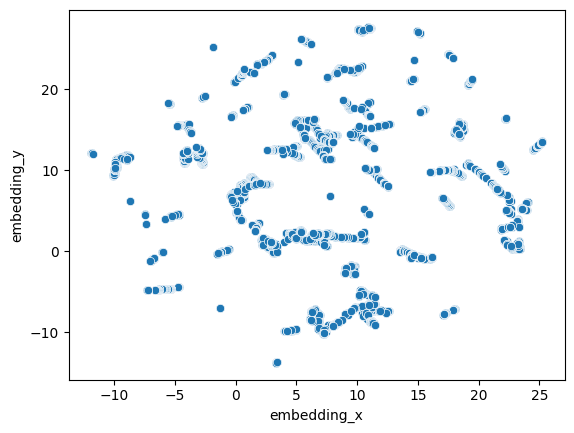

In [36]:
# reduzer dimensionality
#reducer = umap.UMAP( random_state=42 )
#embedding = reducer.fit_transform( df_leaf )

#reducer = pickle.load( open( '../features/umap_reducer.pkl', 'rb' ) )
reducer = pickle.load( fs.open( 's3://insidersdatasetlgm/umap_reducer.pkl', 'rb' ) )
embedding = reducer.transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y', 
                 data=df_tree )

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">5.0. Data Preparation</p></div>      

In [37]:
df5 = df_tree.copy()
#df5.to_csv( '../src/data/tree_based_embedding.csv', index=False ) 

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">7.0. Hiperparameter Fine-Tunning</p></div>      

In [38]:
X = df5.copy()

In [39]:
X.head()

,embedding_x,embedding_y
0,9.100326,-7.936187
1,10.280245,-5.373515
2,10.197146,-6.888188
3,18.505709,14.952629
4,22.483515,6.664168


# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">8.0. Model Training</p></div>       

## 8.1. K-Means

In [40]:
# model definition
k = 8
kmeans = c.KMeans( init='random', n_clusters=k, n_init=100, max_iter=300, random_state=42 )

# model training
kmeans.fit( X )

# clustering 
labels = kmeans.labels_

## 8.2. Cluster Validation

In [41]:
## WSS ( Within-Cluster Sum of Square )
print( 'WSS value: {}'.format(kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( mt.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 109636.90625


SS value: 0.45507267117500305


# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">9.0. Cluster Analysis</p></div>        

In [42]:
df9 = X.copy()
df9['cluster'] = labels

In [43]:
#df92 = df4.copy()
#df9['cluster'] = labels
#df9.head()

## 9.1. Visualization Inspection

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

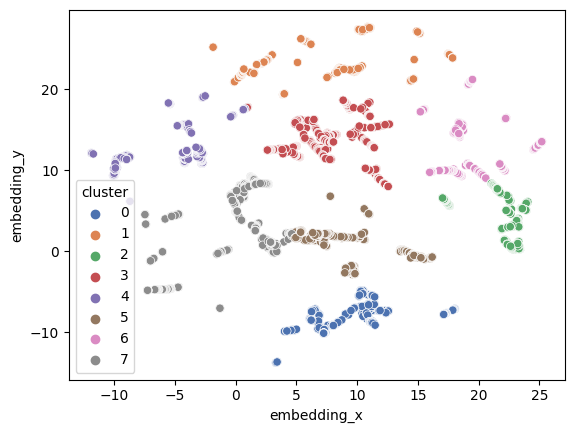

In [44]:
sns.scatterplot( x='embedding_x', y='embedding_y', data=df9, hue='cluster', palette='deep')

## 9.2. Cluster Profile

In [45]:
df92 = df4[cols_selected].copy()
df92['cluster'] = labels
df92.head()

# change dtypes
df92['recency_days'] = df92['recency_days'].astype( 'int64')
df92['qtde_products'] = df92['qtde_products'].astype( 'int64')
df92['qtde_returns'] = df92['qtde_returns'].astype( 'int64')

In [46]:
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_qtde_products = df92[['qtde_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster' )

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )

# Returns
df_qtde_returns = df92[['qtde_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_returns, how='inner', on='cluster' )

df_cluster.sort_values('gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,0,761,13.362599,7305.020683,57.678055,350.819974,0.291262,204.440210
5,5,734,12.888499,2077.506049,110.404632,158.164850,0.487801,0.681199
7,7,1035,18.173837,1365.309256,105.845411,74.311111,0.530281,6.575845
1,1,629,11.044776,708.507472,148.189189,31.848967,0.437934,5.985692
4,4,635,11.150132,701.017181,110.623622,34.206299,0.594508,4.335433
2,2,500,8.779631,557.608580,106.548000,12.486000,0.181173,5.170000
6,6,426,7.480246,404.508779,105.732394,12.187793,0.611501,4.110329
3,3,975,17.120281,272.089179,174.003077,14.540513,1.009477,4.445128


- 0 Cluster Insiders
- 5 Cluster Loyals
- 7 Cluster More Products
- 1 Cluster More Frequency
- 4 Cluster Need Attention
- 2 Cluster At Risk
- 6 Cluster Hibernating
- 3 Cluster More Buy

In [47]:
clusters_list = [0, 5, 7, 1, 4, 2, 6, 3]
for i in clusters_list:
    print(f""" Cluster {df_cluster['cluster'][i]}:
    -Número de Customers: {df_cluster['customer_id'][i]} ({round(df_cluster['perc_customer'][i])}%)
    -Faturamento Médio: ${round(df_cluster['gross_revenue'][i])}
    -Recencia Média: {round(df_cluster['recency_days'][i])} 
    -Média de Produtos Comprados: {round(df_cluster['qtde_products'][i])}  
    -Frequência do Produtos comprados/mês: {round((df_cluster['frequency'][i])*30 ,1)} 
    -Média de Produtos Devolvidos: {round(df_cluster['qtde_returns'][i])} """)

 Cluster 0:
    -Número de Customers: 761 (13%)
    -Faturamento Médio: $7305
    -Recencia Média: 58 
    -Média de Produtos Comprados: 351  
    -Frequência do Produtos comprados/mês: 8.7 
    -Média de Produtos Devolvidos: 204 
 Cluster 5:
    -Número de Customers: 734 (13%)
    -Faturamento Médio: $2078
    -Recencia Média: 110 
    -Média de Produtos Comprados: 158  
    -Frequência do Produtos comprados/mês: 14.6 
    -Média de Produtos Devolvidos: 1 
 Cluster 7:
    -Número de Customers: 1035 (18%)
    -Faturamento Médio: $1365
    -Recencia Média: 106 
    -Média de Produtos Comprados: 74  
    -Frequência do Produtos comprados/mês: 15.9 
    -Média de Produtos Devolvidos: 7 
 Cluster 1:
    -Número de Customers: 629 (11%)
    -Faturamento Médio: $709
    -Recencia Média: 148 
    -Média de Produtos Comprados: 32  
    -Frequência do Produtos comprados/mês: 13.1 
    -Média de Produtos Devolvidos: 6 
 Cluster 4:
    -Número de Customers: 635 (11%)
    -Faturamento Médio: $701
 

### Cluster 01: (Candidato à Insider)
    - Número de Customers: 761 (13%)
    - Faturamento Médio: $7305
    - Recencia Média: 58 
    - Média de Produtos Comprados: 351  
    - Frequência do Produtos comprados/mês: 8.7 
    - Média de Produtos Devolvidos: 204

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">10.0. Análise Exploratória de Dados</p></div>         

In [48]:
df10 = df92.copy()

In [49]:
df10.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372,297,17.000000,40,0
1,13047,3232.59,56,171,0.028302,35,0
2,12583,6705.38,2,232,0.040323,50,0
3,13748,948.25,95,28,0.017921,0,6
4,15100,876.00,333,3,0.073171,22,2


## 10.2. Hipóteses de Negócio

In [51]:
Cluster | Variável para testar | Base de Comparação

SyntaxError: invalid syntax (2683413339.py, line 1)

### Hipótese Compra

1. Os clientes do cluster insiders usam cartão de crédito em 80% das compras.
2. Os clientes do cluster insiders possuem um ticket médio de 10% acima do cluster More Products
3. Os clientes do cluster insiders possuem um basket size acima de 5 produtos.
4. **Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras.**
5. **Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras.**
6. **Os clientes do cluster insiders tem um número de devolução abaixo da média da base total de clientes.**
7. **A mediana do faturamento pelos clientes do cluster insiders é 10% maior do que a mediana dp faturamento geral.**
8. **O percentil do preço dos produtos comprados pelos clientes insiders.**

### H1: Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras.
**Verdade:** Os cluster insiders possuem um volume de compra de produtos de 50%

In [54]:
# soma da qtde de produtos do insiders
df_sales_insiders = df10.loc[df10['cluster'] == 0, 'qtde_products'].sum()
df_sales_total = df10.loc[:, 'qtde_products'].sum()

# soma da qtde de produtos total
print( '% Sales Insiders: {:.2f}%'.format( 100*df_sales_insiders/df_sales_total ) )

% Sales Insiders: 50.63%


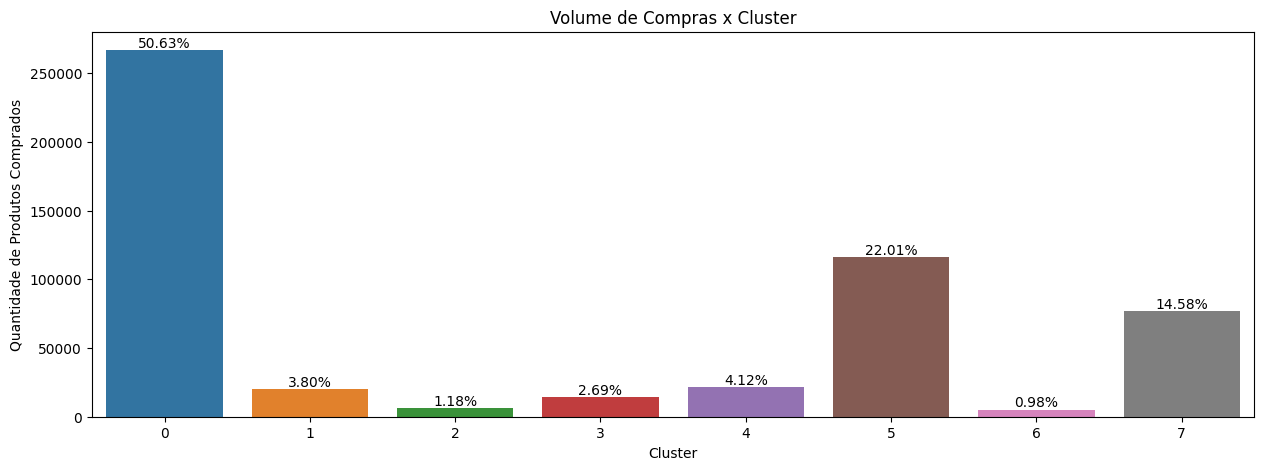

In [96]:
aux = df10[['cluster', 'qtde_products']].groupby('cluster').sum().reset_index()
aux['perc'] = round((aux.qtde_products / aux.qtde_products.sum() * 100 ), 2)
sns.barplot(data=aux, x='cluster', y='qtde_products', errorbar=None);
for index, row in aux.iterrows():
    plt.annotate(f'{row["perc"]:.2f}%', (index, row['qtde_products']), ha='center', va='bottom' )
plt.title( 'Volume de Compras x Cluster')
plt.xlabel( 'Cluster')
plt.ylabel( 'Quantidade de Produtos Comprados');
plt.savefig('../../reports/figures/hipotese01.png')
plt.show()

### H2: Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras.
**Verdadeiro:** O cluster insiders possuem um volume de GMV de 55%

In [55]:
# soma da qtde de produtos do insiders
df_gmv_insiders = df10.loc[df10['cluster'] == 0, 'gross_revenue'].sum()
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()

# soma da qtde de produtos total
print( '% GMV Insiders: {:.2f}%'.format( 100*df_gmv_insiders/df_gmv_total ) )

% GMV Insiders: 55.02%


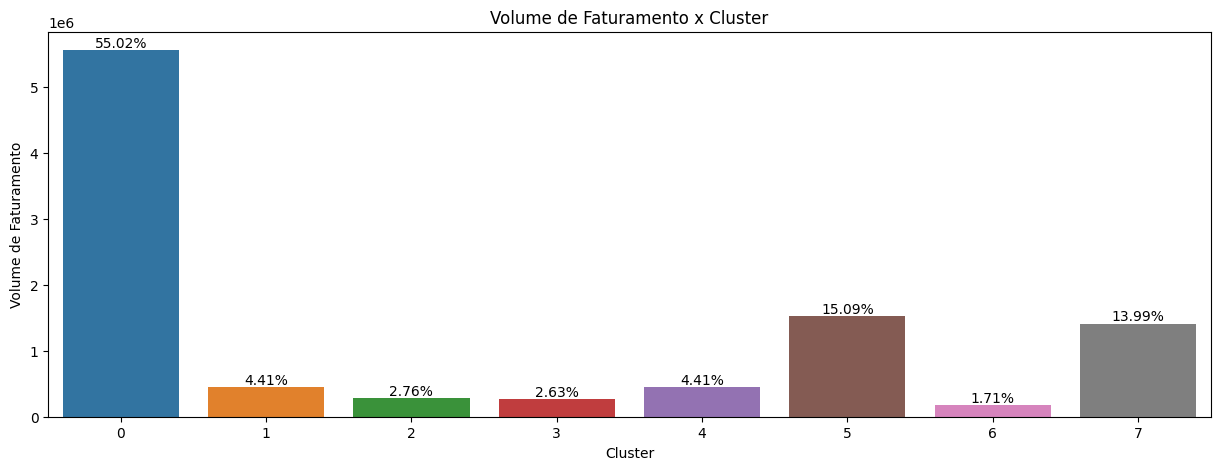

In [97]:
aux = df10[['cluster', 'gross_revenue']].groupby('cluster').sum().reset_index()
aux['perc'] = round((aux.gross_revenue / aux.gross_revenue.sum() * 100 ), 2)
sns.barplot(data=aux, x='cluster', y='gross_revenue', errorbar=None);
for index, row in aux.iterrows():
    plt.annotate(f'{row["perc"]:.2f}%', (index, row['gross_revenue']), ha='center', va='bottom' )
plt.title( 'Volume de Faturamento x Cluster')
plt.xlabel( 'Cluster')
plt.ylabel( 'Volume de Faturamento');
plt.savefig('../../reports/figures/hipotese02.png')
plt.show()

### H3: Os clientes do cluster insiders tem um número de devolução abaixo da média da base total de clientes.
**Falso** O cluster insiders tem média de devoluções acima da média geral

In [100]:
# média de devolução do cluster insider
df_avg_return_insiders = df10.loc[df10['cluster'] == 0, 'qtde_returns'].mean()

# média de devolução do total
df_avg_return_all = df10['qtde_returns'].mean()

print( 'Avg Return Insiders: {} vs Avg Return All: {}'.format( np.round( df_avg_return_insiders, 0 ), np.round( df_avg_return_all, 0 ) ) )

Avg Return Insiders: 204.0 vs Avg Return All: 31.0


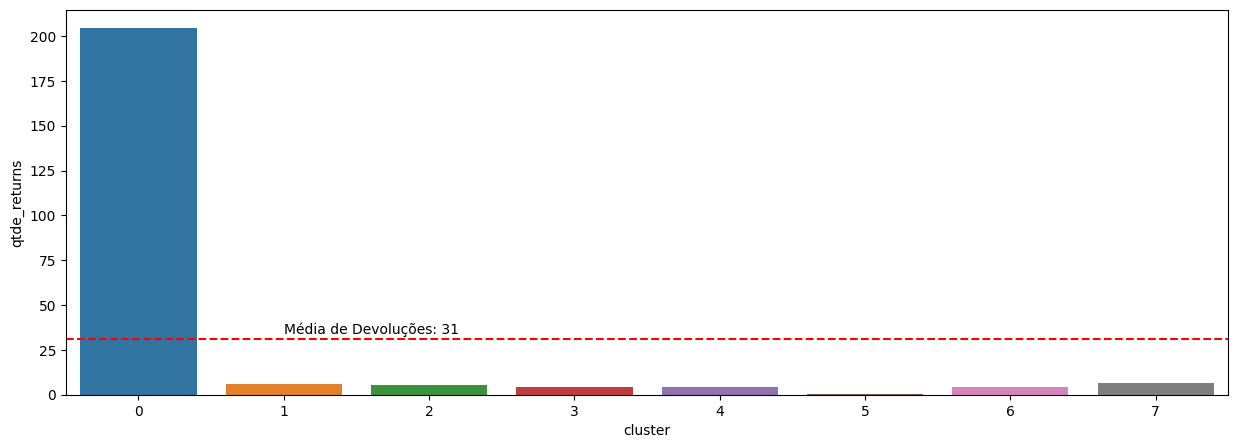

In [108]:
ax= sns.barplot( data=df10, x='cluster', y='qtde_returns', errorbar=None )
ax.axhline( y=df_avg_return_all, color='r', linestyle='--')
ax.text(1, df_avg_return_all + 3, 'Média de Devoluções: 31', color='black')
plt.savefig('../../reports/figures/hipotese03.png')

### H4: A mediana do faturamento pelos clientes do cluster insiders é 10% maior do que a mediana dp faturamento geral.
**Verdadeiro** A média do faturamento é 477% acima da média.

In [57]:
# mediana de gmv do insiders
df_median_gmv_insiders = df10.loc[df10['cluster'] == 0, 'gross_revenue'].median()

# mediana de gmv do total
df_median_gmv_total = df10.loc[:, 'gross_revenue'].median()

gmv_diff = ( df_median_gmv_insiders - df_median_gmv_total ) / df_median_gmv_total
print( 'Median Diff: {:.2f}%'.format( 100*gmv_diff ) )

Median Diff: 477.92%


### H5: O gmv dos clientes insiders esta concentrados no 3º quartil.
**Falso** O faturamento do cluster insiders está concentrado no quartil 1

<Axes: xlabel='gross_revenue'>

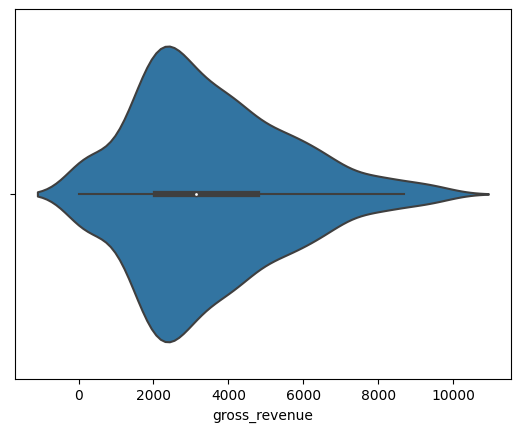

In [81]:
df_aux = df10.loc[(df10['cluster'] == 0) & (df10['gross_revenue'] < 10000 ), 'gross_revenue'];
sns.violinplot( x=df_aux ) 

### Hipótese Cliente

1. 60% dos clientes do cluster insiders possuem o estado civil de solteiro.
2. 10% dos clientes do cluster insiders estão na faixa de 24-35 anos.
3. 40% das localidades de entrega do cluster insiders estão dentro de um raio de 50km.
4. 5% dos clientes do cluster insiders recebem mais de 100 mil dólares anualmente.
5. 90% dos clientes do cluster insiders tem ensino superior completo.

### Hipótese Produto

1. 30% de todos os produtos em pacotes grandes são comprados pelos clientes do cluster insiders.
2. A mediana dos preços dos produtos comprados pelos clientes do cluster insiders é 10% maior do que a mediana de todos os preços dos produtos.
3. O percentil do preço dos produtos comprados pelos clientes insiders.
4. O peso médio dos produtos comprados pelos clientes do cluster insiders é maior do que o peso médio dos outros clusters.
5. A idade média dos produtos comprados pelos clientes do cluster insiders é menor do que 15 dias.

### Perguntas de Negócio

### 1. Quem são as pessoas elegíveis para participar do programa de Insiders?

In [52]:
df10.loc[df10['cluster'] == 0, 'customer_id'].head()

0    17850
1    13047
2    12583
5    15291
6    14688
Name: customer_id, dtype: int64

### 2. Quantos clientes farão parte do grupo?

In [53]:
df10.loc[df10['cluster'] == 0, 'customer_id'].size

761

### 3. Quais as principais características desses clientes?

#### Cluster 01: (Candidato à Insider)
    - Número de Customers: 761 (13%)
    - Faturamento Médio: $7305
    - Recencia Média: 58 
    - Média de Produtos Comprados: 351  
    - Frequência do Produtos comprados/mês: 8.7 
    - Média de Produtos Devolvidos: 204

### 4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders?

In [54]:
df_insiders_gmv = df10.loc[df10['cluster'] == 0, 'gross_revenue'].sum()
df_all_gmv = df10.loc[:, 'gross_revenue'].sum()

print( '% GMV from Insiders: {}'.format( df_insiders_gmv / df_all_gmv ) )

% GMV from Insiders: 0.5501729803170662


### 5. Qual a expectativa de faturamento desse grupo para os próximos meses?

### 6. Quais as condições para uma pessoa ser elegível ao Insiders?

### 7. Quais as condições para uma pessoa ser removida do Insiders?

8. Qual a garantia que o programa Insiders é melhor que o restante da base?

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

## 10.3. Priorização das Hipótese

## 10.4 Validação das Hipóteses

## 10.5. Quadro de Respostas

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">11.0. Deploy to Production</p></div>         

In [59]:
df92.dtypes

customer_id        int64
gross_revenue    float64
recency_days       int64
qtde_products      int64
frequency        float64
qtde_returns       int64
cluster           object
dtype: object

In [53]:
cluster_name = {0:'Insiders', 5:'Loyals', 7:'More Products', 1:'More Frequency', 4:'Need Attention', 2:'At Risk', 6:'Hibernating', 3:'More Buy'}
df92['cluster'] = df92['cluster'].map( cluster_name)

## 11.1. Insert into SQLITE

In [56]:
DB_HOST = config('DB_HOST')
DB_PORT = config('DB_PORT')
DB_NAME = config('DB_NAME')
DB_USER = config('DB_USER')
DB_PASSWORD = config('DB_PASSWORD')

In [57]:
# database conection
#endpoint = 'sqlite:///insiders_db.sqlite'

endpoint=f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}/postgres' 

engine = sqlalchemy.create_engine( endpoint )

# create table
query_create_insiders = """
    CREATE TABLE insiders (
        customer_id      INTEGER,
        gross_revenue    REAL,
        recency_days     INTEGER,
        qtde_products    INTEGER,
        frequency        REAL,
        qtde_returns     INTEGER,
        cluster          TEXT 
    
    )
"""

In [58]:
with engine.connect() as connection:
    df92.to_sql('insiders', con=connection, if_exists='replace', index=False)

In [ ]:
#df92.to_sql ( 'insiders', con=conn, if_exists='append', index=False )

In [ ]:
## get query
#query_collect = """
#    SELECT * FROM insiders"""
#
#df = pd.read_sql_query( query_collect, connection )
#df.head()